In [1]:
import optuna
import pickle
import torch
import os
import sys
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
from matplotlib.ticker import MultipleLocator

# Add the root folder to Python path
root_folder = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_folder not in sys.path:
    sys.path.append(root_folder)

import lib.unet_nn as UNet
import lib.modified_aggregation as MA
from lib.modified_aggregation_clusterer import ModifiedAggregationClusterer
from lib.unet_clusterer import UNetClusterer
from lib.focal import FocalH
from lib.base_nn import Data
from lib.metrics import count_clusters, count_labels, compute_score

os.chdir('/home/bjartur/workspace/python_focalh_clustering/') # Laptop and Desktop

# Study overview

In [105]:
study_file = "studies/study_ma_07092025_111321.pkl"
with open(study_file, "rb") as f:
    loaded_bundle = pickle.load(f)
print(f"bundle: \n{loaded_bundle}")
print()
print(f"study: {loaded_bundle['study'].best_params}")
print(loaded_bundle["timestamps"])

bundle: 
{'method': {'name': 'ma', 'parameters': [{'name': 'seed', 'type': 'float', 'min': 0, 'max': 4096}, {'name': 'agg', 'type': 'float', 'min': 0, 'max': 4096}]}, 'study': <optuna.study.study.Study object at 0x7392d3f2d710>, 'data': {'name': 'small test set', 'files': [{'path': 'data/train/TRAIN_E150_P3_N100.root', 'particles': 3, 'saturation': 4096, 'meta': {'source': 'mc', 'detector': 'prototype2'}}, {'path': 'data/train/TRAIN_E350_P1_N100.root', 'particles': 1, 'saturation': 4096, 'meta': {'source': 'mc', 'detector': 'prototype2'}}, {'path': 'data/train/TRAIN_E60_P1_N100.root', 'particles': 1, 'saturation': 4096, 'meta': {'source': 'mc', 'detector': 'prototype2'}}]}, 'its': 10, 'timestamps': {'t_optimize_start': 1757236399.2037368, 't_data_loaded': 1757236399.399521, 't_study_finished': 1757236401.3330517, 't_optimize_end': 1757236401.3331945}}

study: {'seed': 1859.7543805795672, 'agg': 761.7806117481223}
{'t_optimize_start': 1757236399.2037368, 't_data_loaded': 1757236399.3995

In [106]:
loaded_bundle["timestamps"]["t_optimize_end"] - loaded_bundle["timestamps"]["t_optimize_start"]

2.129457712173462

In [3]:
def lst_test(par1=None, par2=None, par3=None):
    print(f"par1: {par1}")
    print(f"par2: {par2}")
    print(f"par3: {par3}")
lst = ["adsf", "bla"]
lst_test(*lst)

par1: adsf
par2: bla
par3: None


# Evaluate studies

In [4]:
ma_study_file = "studies/best/study_ma_24082025_133543.pkl"

cnn_study_file = "studies/study_cnn_24082025_132142.pkl"
cnn_model_file = "studies/model_cnn_24082025_132142.pt"

In [6]:
with open(ma_study_file, "rb") as f:
    loaded_bundle = pickle.load(f)
ma_study = loaded_bundle
ma = MA.ModifiedAggregation(ma_study["study"].best_params["seed"], ma_study["study"].best_params["agg"])
#ma = MA.ModifiedAggregation(1400, 0)
ma_study["exec"] = ma
ma_study["study"].best_params
ma_study

{'method': 'ma',
 'study': <optuna.study.study.Study at 0x70cb46970b10>,
 'config': {'analysis': {'type': 'standard',
   'files': [{'path': 'data/E150_P5_N1000.root',
     'particles': 5,
     'saturation': 4096,
     'meta': {'source': 'mc', 'detector': 'prototype2'}},
    {'path': 'data/E150_P3_N1000.root',
     'particles': 3,
     'saturation': 4096,
     'meta': {'source': 'mc', 'detector': 'prototype2'}}]}},
 'its': 100,
 'exec': <lib.modified_aggregation.ModifiedAggregation at 0x70cb488ff210>}

In [6]:
with open(cnn_study_file, "rb") as f:
    loaded_bundle = pickle.load(f)
u = torch.load(cnn_model_file, weights_only=False)
cnn_study = loaded_bundle
cnn_study["exec"] = u
cnn_study["study"].best_params

{'seed': 0.5,
 'agg': 0.0,
 'lr': 0.5625913914829032,
 'momentum': 0.841114016126484,
 'epochs': 92}

12209.0
4095.0


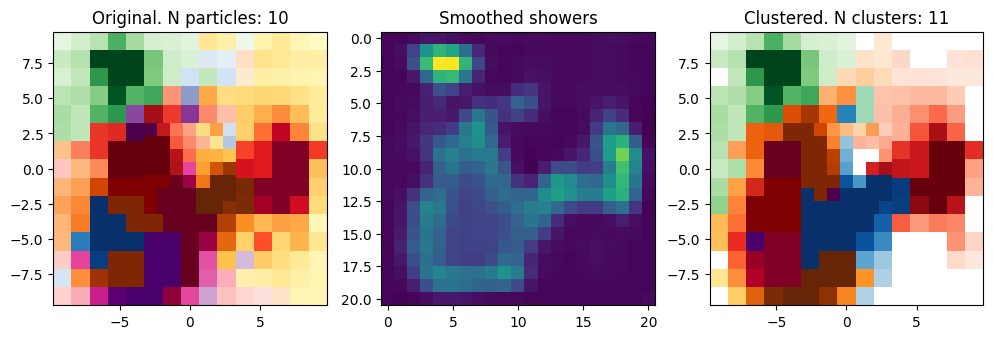

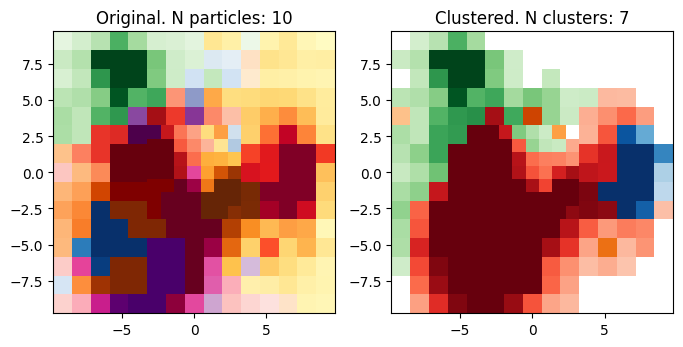

In [14]:
def cluster_event(tfile, entry, study):
    """
    Just try clustering an event and view it.
    """
#    study["exec"]

    SAT = 4096
    tfile = ROOT.TFile(tfile, "READ")
    ttree = tfile.Get("EventsTree")
    ttree.GetEntry(entry)

    nplab = np.array(ttree.labels, dtype=np.int32)
    npfrac = np.array(ttree.fractions, dtype=np.float32)
    npvals = np.array(ttree.value, dtype=np.float32)
    valmask = npvals > SAT
    npvals[valmask] = SAT
    particles = len(set(nplab))
    
    dataloader = Data()
    npdlab = dataloader.get_major_labels(nplab, npfrac, particles)




    if study["method"] == "ma":
        iadj = np.load("../p2_sim_adj_map2.npy")
        adj = np.load("../p2_adj.npy")
        fig, ax = plt.subplots(ncols=2, figsize=(8,4))        
        foc = FocalH()
        foc.heatmap(npvals[iadj], npdlab[iadj], ax[0], SAT)
        clabels,_ = study["exec"].run(adj, npvals[iadj])
        foc.heatmap(npvals[iadj], clabels, ax[1], SAT)
        ax[0].set_title(f"Original. N particles: {count_labels(npdlab)}")
        ax[1].set_title(f"Clustered. N clusters: {count_clusters(clabels)}")

        fig.savefig(study["method"]+"_P"+str(particles)+"_EV"+str(entry))
            
    elif study["method"] == "cnn":
        iadj = np.load("../p2_sim_adj_map2.npy")
        adj = np.load("../p2_image_adj_21x21.npy")
        fig, ax = plt.subplots(ncols=3, figsize=(12,4))        
        foc = FocalH()
        foc.heatmap(npvals[iadj], npdlab[iadj], ax[0], SAT)
        ret, coms, dlabels, mapping = dataloader.read_ttree_event(ttree, entry)
        #target = dataloader.gaussian_class_activation_map(coms, 21, 21, 3)[0][0]

        x = study["exec"](ret)[0][0]
        vals = x.flatten().detach().numpy()
#        vals = vals / vals.max()
        ax[1].imshow(x.detach().numpy())

        seed = study["study"].best_params["seed"]
        agg = study["study"].best_params["agg"]
#        clusterizer = MA.ModifiedAggregation(seed,agg)
        clusterizer = MA.ModifiedAggregation(0.2,0)
        clabels,_ = clusterizer.run(adj,vals)

        clabels = dataloader.invert_labels(clabels, mapping, vals, npdlab.shape[0])
#        print(vals.max())
        foc.heatmap(npvals[iadj], clabels.astype(np.int32), ax[2], SAT)
        ax[0].set_title(f"Original. N particles: {count_labels(npdlab)}")
        ax[1].set_title(f"Smoothed showers")
        ax[2].set_title(f"Clustered. N clusters: {count_clusters(clabels)}")

        fig.savefig(study["method"]+"_P"+str(particles)+"_EV"+str(entry))

        

    
    

    
filename = "/home/bjartur/workspace/python_focalh_clustering/data/E300_P10_N1000.root"
entry = 400
cluster_event(filename, entry, cnn_study)
cluster_event(filename, entry, ma_study)

# Analyse study

## MA

In [8]:
ma_study_file = "studies/study_ma_29082025_095625.pkl"
with open("analysis/data.yaml", "r") as file:
    data_config = yaml.safe_load(file)
with open(ma_study_file, "rb") as f:
    loaded_bundle = pickle.load(f)
ma_study = loaded_bundle
ma_pars = ma_study["study"].best_params
ma_cluster = ModifiedAggregationClusterer()
adj, values, labels = ma_cluster.data(data_config["eval_test"])
ma_tags = ma_cluster.cluster(ma_pars["seed"], ma_pars["agg"], adj, values)


In [9]:
score = compute_score(ma_tags, labels, values, "average_energy")
count = compute_score(ma_tags, labels, values, "count_labels")
idx = np.linspace(0,len(count)-1,len(count), dtype=np.int32)

In [16]:
def plot_discrete(x,y):
    unq = np.unique(x)
    muy = np.zeros_like(unq)
    mux = np.zeros_like(unq)
    sigmay = np.zeros_like(unq)
    sigmax = np.zeros_like(unq)
    for i in range(len(unq)):
        mask = x == unq[i]
        muy[i] = y[mask].mean()
        mux[i] = x[mask].mean()
        sigmay[i] = y[mask].std()/np.sqrt(len(y[mask]))
        sigmax[i] = x[mask].std()/np.sqrt(len(x[mask]))

    plt.errorbar(mux,muy,sigmay,marker=".",linestyle="")
    plt.ylim(0,2)

#plot_discrete(count, score)

In [11]:
count_mask = count == 4
badscore = score[idx[count_mask]].argmax()
badidx = idx[count_mask][badscore]

<Axes: >

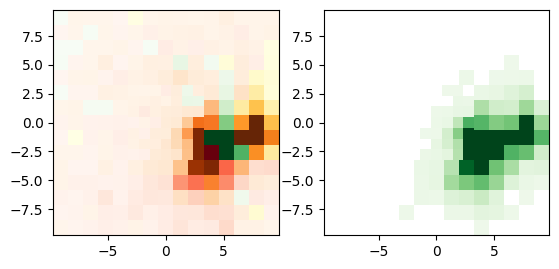

In [12]:
SAT = 4095
fig, ax = plt.subplots(ncols=2)
foc = FocalH()
foc.heatmap(values[badidx], labels[badidx], ax[0], SAT)
foc.heatmap(values[badidx], ma_tags[badidx], ax[1], SAT)

#ma_tags[1]

## CNN

In [29]:
with open("studies/study_cnn_01092025_153611.pkl", "rb") as f:
    loaded_bundle2 = pickle.load(f)
loaded_bundle2
u2 = torch.load(cnn_model_file, weights_only=False)

{'method': {'name': 'cnn',
  'parameters': [{'name': 'seed',
    'type': 'float',
    'relative': True,
    'min': 0.2,
    'max': 0.2},
   {'name': 'agg', 'type': 'float', 'relative': True, 'min': 0.0, 'max': 0.0},
   {'name': 'lr', 'type': 'float', 'min': 0.001, 'max': 1},
   {'name': 'momentum', 'type': 'float', 'min': 0.01, 'max': 1},
   {'name': 'epochs', 'type': 'int', 'min': 50, 'max': 200}]},
 'study': <optuna.study.study.Study at 0x74167d356a50>,
 'data': {'name': 'small test set',
  'files': [{'path': 'data/train/TRAIN_E350_P1_N100.root',
    'particles': 1,
    'saturation': 4096,
    'meta': {'source': 'mc', 'detector': 'prototype2'}},
   {'path': 'data/train/TRAIN_E150_P3_N100.root',
    'particles': 3,
    'saturation': 4096,
    'meta': {'source': 'mc', 'detector': 'prototype2'}},
   {'path': 'data/train/TRAIN_E60_P1_N100.root',
    'particles': 1,
    'saturation': 4096,
    'meta': {'source': 'mc', 'detector': 'prototype2'}}]},
 'its': 100,
 'model_file': 'model_cnn_01

In [2]:
#cnn_study_file = "studies/study_cnn_24082025_132142.pkl"
#cnn_model_file = "studies/model_cnn_24082025_132142.pt"
cnn_study_file = "studies/study_cnn_01092025_153611.pkl"

with open(cnn_study_file, "rb") as f:
    loaded_bundle = pickle.load(f)
with open("analysis/data.yaml", "r") as file:
    data_config = yaml.safe_load(file)
cnn_study = loaded_bundle
u = torch.load("studies/"+cnn_study["model_file"], weights_only=False)
cnn_study["exec"] = u

pars = cnn_study["study"].best_params
unet_cluster = UNetClusterer()
events, targets, counts, mapping, dlabels, values, energy_list, adj = unet_cluster.data(data_config["eval_test"])

tags = unet_cluster.cluster(events, u, pars["seed"], pars["agg"], adj, dlabels, mapping)


#tags = unet_cluster.cluster(events, u, 0.2, pars["agg"], adj, dlabels, mapping)


labels = dlabels.squeeze()
values = values.squeeze()



In [3]:
print(pars)


{'seed': 0.2, 'agg': 0.0, 'lr': 0.30884943833786427, 'momentum': 0.0525593791377537, 'epochs': 177}


In [5]:
adj = np.load("p2_image_adj_21x21.npy")
iadj = np.load("p2_sim_adj_map2.npy")


tensor([ 1,  1,  5,  1,  1,  9,  1,  5,  1,  1,  4,  1,  1,  1,  1,  1,  1,  4,
         4,  4,  1,  4,  4,  4,  4,  1,  1,  6,  1,  6,  1,  1,  1,  5,  6,  1,
         1,  5,  5,  6,  1,  5,  5,  5,  6,  5,  5,  5,  5,  5,  6,  6, 10, 10,
        10,  6,  6, 10, 10, 10,  6,  6, 10, 10, 10,  6,  6,  6, 10, 10,  6,  6,
        10,  6,  6,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
         7,  4,  8,  7,  7,  8,  8,  7,  5,  7,  5,  5,  5,  5,  5,  5,  6,  4,
         7,  7,  7,  5,  5,  5,  9,  4,  7,  7,  7,  7,  7,  7,  9,  9,  9,  7,
         7,  7,  7,  9,  9,  9,  7,  7,  7,  7,  9,  9,  9,  7,  7,  3,  7,  7,
         9,  9,  7,  3,  3,  6,  6, 10,  6,  9,  7,  5, 10, 10, 10,  9,  3,  3,
        10,  9,  3,  3,  3, 10, 10,  7,  7,  7, 10, 10,  8,  8,  8,  8,  9,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  9,  9,  3,  3,  3,  7,  9,  7,  3,  3,  8,  3,  3,  3,  3,  8, 10,
         3,  3,  3,  8,  3,  3,  3,  7, 

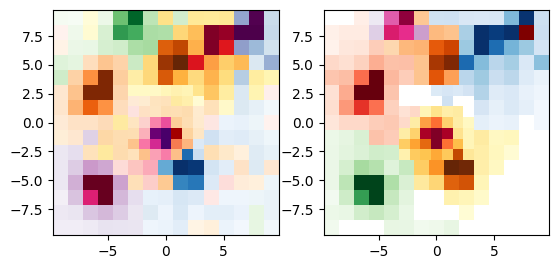

In [15]:
fig, ax = plt.subplots(ncols=2)
foc = FocalH()
idx = 1500
SAT = 4095
# Map values and labels with original sim data.
foc.heatmap(values[idx][iadj], labels[idx][iadj], ax[0], SAT)

# Map original values only. Tags are already mapped.
#foc.heatmap(values[idx][iadj], tags[idx][iadj], ax[1], SAT)
foc.heatmap(values[idx][iadj], tags[idx], ax[1], SAT)
print(labels[idx][iadj])
print(tags[idx])

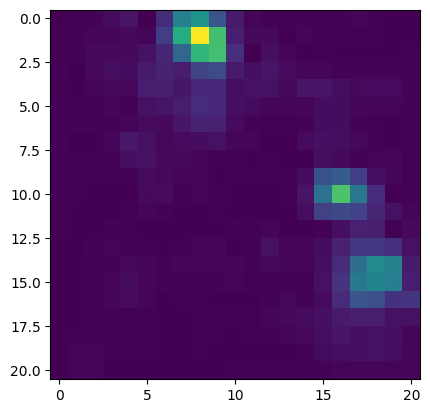

In [14]:
img = events[idx].squeeze()
plt.imshow(img)

In [25]:
tags

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 3., 3., 0.]])

# Sklearn

In [11]:
hdbscan_study_file = "studies/study_hdbscan_03092025_192825.pkl"

with open(hdbscan_study_file, "rb") as f:
    loaded_bundle = pickle.load(f)
hdbscan_study = loaded_bundle
print(hdbscan_study["study"].best_params)
hdbscan_study

{'trans::type': 'multiply', 'trans::factor': 50, 'trans::width': 1.4525251, 'method::min_samples': 1, 'method::min_cluster_size': 49, 'method::allow_single_cluster': True}


{'method': {'name': 'hdbscan',
  'labels': True,
  'parametric': False,
  'parameters': [{'name': 'min_samples', 'type': 'int', 'min': 1, 'max': 20},
   {'name': 'min_cluster_size', 'type': 'int', 'min': 2, 'max': 200},
   {'name': 'allow_single_cluster', 'type': 'bool'}]},
 'study': <optuna.study.study.Study at 0x7392ddbf5310>,
 'data': {'name': 'small test set',
  'files': [{'path': 'data/train/TRAIN_E150_P3_N100.root',
    'particles': 3,
    'saturation': 4096,
    'meta': {'source': 'mc', 'detector': 'prototype2'}},
   {'path': 'data/train/TRAIN_E350_P1_N100.root',
    'particles': 1,
    'saturation': 4096,
    'meta': {'source': 'mc', 'detector': 'prototype2'}},
   {'path': 'data/train/TRAIN_E60_P1_N100.root',
    'particles': 1,
    'saturation': 4096,
    'meta': {'source': 'mc', 'detector': 'prototype2'}}]},
 'its': 10}

# Analyse study stability

Probably a good thing to, for each study, be able to show if the parameters seem to converge.

# Curtain test

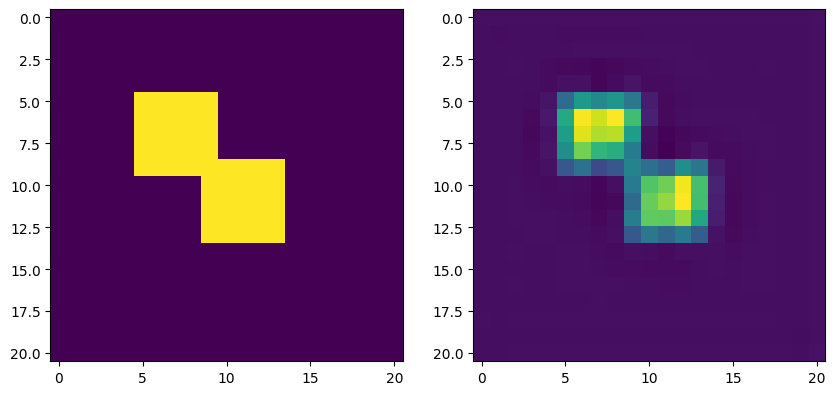

In [47]:
x_synth = np.zeros(21*21, dtype=np.float32).reshape(21,21)

fig,ax=plt.subplots(ncols=2, figsize=(10,5))

size=5
c1 = (9,9)
b1 = slice(c1[0],c1[0]+size), slice(c1[1],c1[1]+size)


c2 = (5,5)
b2 = slice(c2[0],c2[0]+size), slice(c2[1],c2[1]+size)


x_synth[b1] = 1
x_synth[b2] = 1

x_synth_tensor = torch.from_numpy(x_synth).unsqueeze(0).unsqueeze(0)
x_synth_pred = cnn_study["exec"](x_synth_tensor)
ax[0].imshow(x_synth)
ax[1].imshow(x_synth_pred[0][0].detach().numpy())

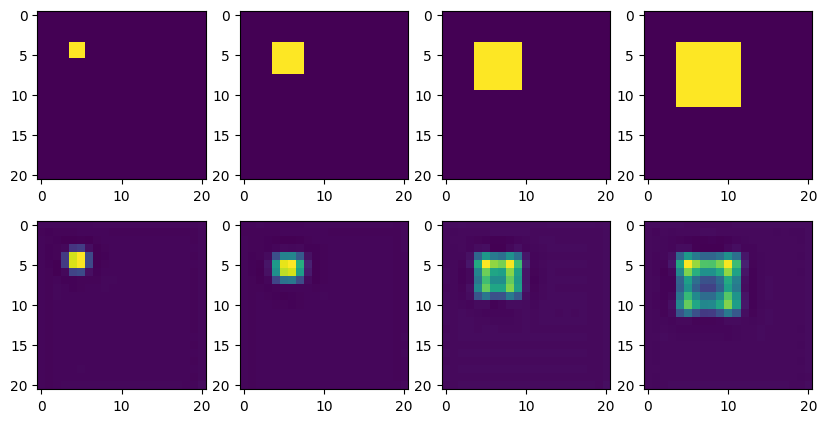

In [58]:
fig,ax=plt.subplots(nrows=2,ncols=4, figsize=(10,5))

for i in range(4):
    i_synth = np.zeros(21*21, dtype=np.float32).reshape(21,21)
    origin = 4,4
    size = 2*(i+1)
    bi = slice(origin[0],origin[0]+size), slice(origin[1],origin[1]+size)
    i_synth[bi] = 1
    
    i_synth_tensor = torch.from_numpy(i_synth).unsqueeze(0).unsqueeze(0)
    i_synth_pred = cnn_study["exec"](i_synth_tensor)
    ax[0][i].imshow(i_synth)
    ax[1][i].imshow(i_synth_pred[0][0].detach().numpy())

fig.savefig("synth_blobs.png", bbox_inches="tight")

# Analyse the magic

Add masks over showers and see if it's able to intelligently reconstruct what is behind the mask (saturated area).

Call it curtain test.

# Analyse evaluation

In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size" : 15,
    "legend.fontsize" : 12,
    "xtick.direction" : "in",
    "ytick.direction" : "in",
    "xtick.major.size" : 5.0,
    "xtick.minor.size" : 3.0,
    "ytick.major.size" : 5.0,
    "ytick.minor.size" : 3.0,
    "axes.linewidth" : 0.8,
    "legend.handlelength" : 2,
})

def plot_discrete(x,y,label=""):
    unq = np.unique(x)
    muy = np.zeros_like(unq)
    mux = np.zeros_like(unq)
    sigmay = np.zeros_like(unq)
    sigmax = np.zeros_like(unq)
    for i in range(len(unq)):
        mask = x == unq[i]
        muy[i] = y[mask].mean()
        mux[i] = x[mask].mean()
        sigmay[i] = y[mask].std()/np.sqrt(len(y[mask]))
        sigmax[i] = x[mask].std()/np.sqrt(len(x[mask]))

    plt.errorbar(mux,muy,sigmay,marker=".",linestyle="", label=label)
    plt.ylim(0,2)
    plt.legend()


def plot_performance_particle_num(df, x_col, y_col, marker_shape="^", linestyle="", color="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    grp = df.groupby(x_col)[y_col]
    mu_x = grp.mean().index
    mu_y = grp.mean().values
    sigma_y = grp.sem().values
    if color == "":
        ax.errorbar(mu_x, mu_y, yerr=sigma_y, marker=marker_shape, linestyle=linestyle, capsize=5)
    else:
        ax.errorbar(mu_x, mu_y, yerr=sigma_y, marker=marker_shape, linestyle=linestyle, color=color, capsize=5)
    #ax.plot(mu_x, mu_y)


def plot_chunks(x, y, Nbins, label, marker_shape=".", color="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    bins = np.linspace(min(x), max(x), Nbins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    mu_y = np.zeros(Nbins)
    sigma_y = np.zeros(Nbins)
    
    for i in range(Nbins):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if np.any(mask):
            mu_y[i] = np.mean(y[mask])
            sigma_y[i] = np.std(y[mask]) / np.sqrt(np.sum(mask))

    if color == "":
        ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker=marker_shape, linestyle='solid', capsize=5)
    else:
        ax.errorbar(bin_centers, mu_y, yerr=sigma_y, marker=marker_shape, linestyle='solid', color=color, capsize=5)




def format_with_suffix(num):
    if num >= 1e9:
        return f"{num / 1e9:.1f}B"
    elif num >= 1e6:
        return f"{num / 1e6:.1f}M"
    elif num >= 1e3:
        return f"{num / 1e3:.1f}K"
    else:
        return str(num)


#plot_discrete(count, score)

In [15]:
#ma_eval_file = "evaluation/eval_ma_01092025_053548.pkl"
#ma_eval_file = "evaluation/eval_ma_07092025_103817.pkl"
#ma_eval_file = "evaluation/eval_ma_06092025_102441.pkl"
ma_eval_file = "evaluation/eval_ma_08092025_092411.pkl"



#cnn_eval_file = "evaluation/eval_cnn_02092025_060217.pkl"
#cnn_eval_file = "evaluation/eval_cnn_02092025_104200.pkl"
#cnn_eval_file = "evaluation/eval_cnn_07092025_094926.pkl"
cnn_eval_file = "evaluation/eval_cnn_07092025_102542.pkl"



#hdbscan_eval_file = "evaluation/eval_hdbscan_03092025_201034.pkl"
hdbscan_eval_file = "evaluation/eval_hdbscan_07092025_103658.pkl"
#hdbscan_eval_file = "evaluation/eval_hdbscan_05092025_113309.pkl"


with open(cnn_eval_file, "rb") as f:
    loaded_bundle = pickle.load(f)
cnn_eval = loaded_bundle


with open(ma_eval_file, "rb") as f:
    loaded_bundle = pickle.load(f)
ma_eval = loaded_bundle


with open(hdbscan_eval_file, "rb") as f:
    loaded_bundle = pickle.load(f)
hdbscan_eval = loaded_bundle


cnn_eval["method"]
cnn_eval["eval"]


for key,value in cnn_eval["eval"].items():
   print(key)

events
targets
counts
mapping
labels
values
energy
coms
adj
tags
data
efficiency
vmeasure
coverage
particles
avg_energy


In [23]:
cnn_eval["eval"]["values"]

array([[ 65.,  33.,  65., ...,  43.,  27.,  27.],
       [  9.,  74., 233., ...,   7.,  10.,  10.],
       [ 13.,  12.,   3., ...,  47.,  62.,  16.],
       ...,
       [  5.,  36.,  19., ...,  49.,  40., 162.],
       [  4.,  45.,  60., ...,   5.,   2.,   3.],
       [ 56.,  24.,  39., ...,  12.,  10.,   0.]], dtype=float32)

<Axes: >

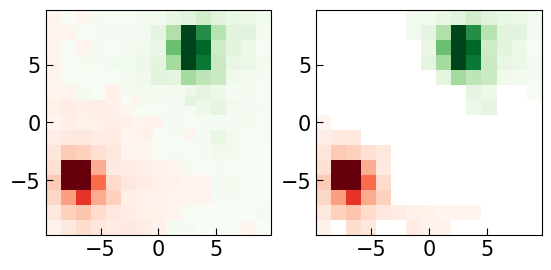

In [55]:
idx = 3000
iadj = np.load("p2_sim_adj_map2.npy")
vals = cnn_eval["eval"]["values"][idx]
labels = cnn_eval["eval"]["labels"][idx]
tags = cnn_eval["eval"]["tags"][idx]

foc = FocalH()
fig,ax = plt.subplots(ncols=2)
foc.heatmap(vals[iadj], labels[iadj], ax[0])
foc.heatmap(vals[iadj], tags, ax[1])


In [24]:
def dist(coms):
    print(len(coms))
    dists = [None]*len(coms)
    for i in range(len(coms)):
        diff = coms[i][:, np.newaxis, :] - coms[i][np.newaxis, :, :]
        dist = np.sqrt((diff ** 2).sum(axis=-1))
        upper_tri = dist[np.triu_indices_from(dist, k=1)]
        dists[i] = upper_tri.mean()
    return dists


def to_dataframe(d):
#    print(d["method"])
    df = pd.DataFrame({
        "efficiency": d["eval"]["efficiency"],
        "vmeasure": d["eval"]["vmeasure"],
#        "vmeasure_weighted": d["vmeasure_weighted"],
        "coverage": d["eval"]["coverage"],
        "particles": d["eval"]["particles"],
        "avg_energy": d["eval"]["avg_energy"],
        "coms_dists" : dist(d["eval"]["coms"]),
                         })
    return df



df_ma = to_dataframe(ma_eval)
df_cnn = to_dataframe(cnn_eval)
df_hdbscan = to_dataframe(hdbscan_eval)

10000


/tmp/ipykernel_33573/1820535683.py:8: RuntimeWarning: Mean of empty slice.
  dists[i] = upper_tri.mean()


9076
10000


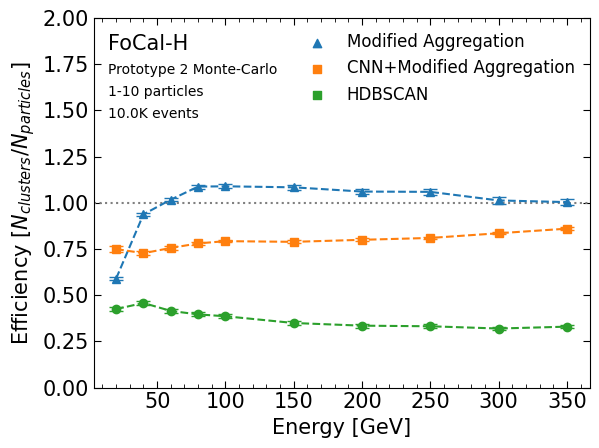

In [11]:

fig,ax = plt.subplots()
plot_performance_particle_num(df_ma, "avg_energy", "efficiency", marker_shape="^", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_cnn, "avg_energy", "efficiency", marker_shape="s", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_hdbscan, "avg_energy", "efficiency", marker_shape="o", linestyle="dashed", ax=ax)
#ax.set_xticks([1,2,3,4,5,6,7,8,9,10], ["1","2","3","4","5","6","7","8","9","10"])
ax.set_xticks([0,50,100,150,200,250,300,350], ["0","50","100","150","200","250","300","350"])
#ax.set_xticks([1,2], ["1","2"])
ax.set_ylim(0,2)
ax.xaxis.set_minor_locator(MultipleLocator(10))
#ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Efficiency [$N_{clusters}/N_{particles}$]")
ax.axhline(1, color="grey", linestyle="dotted")
ax.scatter([],[], label="Modified Aggregation", marker="^")
ax.scatter([],[], label="CNN+Modified Aggregation", marker="s")
ax.scatter([],[], label="HDBSCAN", marker="s")
ax.legend(framealpha=0)

#ax.text(0.00, 1.05, "FoCal-H Prototype 2", transform=plt.gca().transAxes, ha="left", va="center")
#ax.text(1.00, 1.05, f"${len(df_ma):.0E}$ MC Events", transform=plt.gca().transAxes, ha="right", va="center")


ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"1-10 particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"{format_with_suffix(len(df_ma))} events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)


#ax.grid(True)
fig.savefig("eval_eff_energy_many.png", bbox_inches="tight")

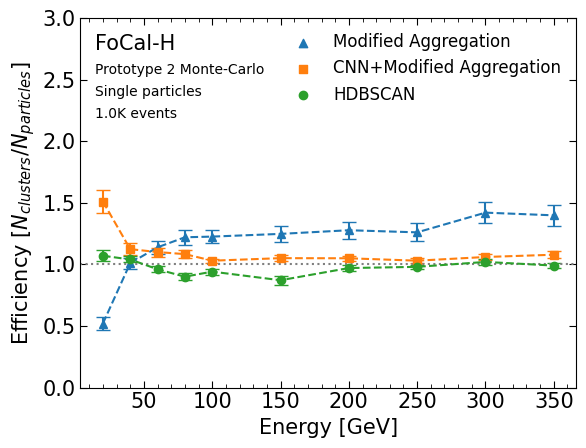

In [12]:
ma_single = df_ma["particles"] == 1
cnn_single = df_cnn["particles"] == 1
hdbscan_single = df_hdbscan["particles"] == 1

fig,ax = plt.subplots()
plot_performance_particle_num(df_ma[ma_single], "avg_energy", "efficiency", marker_shape="^", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_cnn[cnn_single], "avg_energy", "efficiency", marker_shape="s", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_hdbscan[hdbscan_single], "avg_energy", "efficiency", marker_shape="o", linestyle="dashed", ax=ax)
#ax.set_xticks([1,2,3,4,5,6,7,8,9,10], ["1","2","3","4","5","6","7","8","9","10"])
ax.set_xticks([0,50,100,150,200,250,300,350], ["0","50","100","150","200","250","300","350"])
#ax.set_xticks([1,2], ["1","2"])
ax.set_ylim(0,3)
ax.xaxis.set_minor_locator(MultipleLocator(10))
#ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Efficiency [$N_{clusters}/N_{particles}$]")
ax.axhline(1, color="grey", linestyle="dotted")
ax.scatter([],[], label="Modified Aggregation", marker="^")
ax.scatter([],[], label="CNN+Modified Aggregation", marker="s")
ax.scatter([],[], label="HDBSCAN", marker="o")
ax.legend(framealpha=0)

ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"Single particles", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"{format_with_suffix(len(df_ma[ma_single]))} events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)

fig.savefig("eval_eff_energy_single.png", bbox_inches="tight")

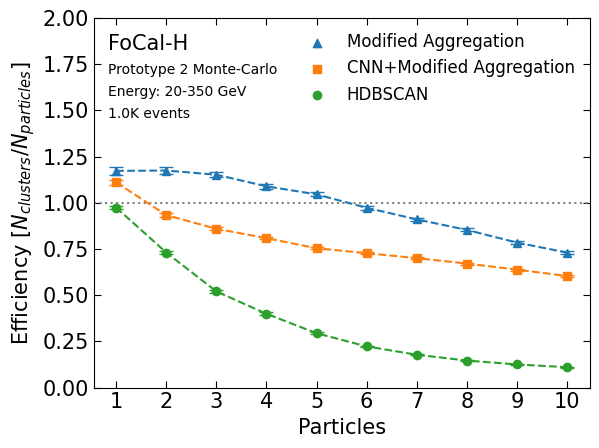

In [13]:
fig,ax = plt.subplots()
plot_performance_particle_num(df_ma, "particles", "efficiency", marker_shape="^", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_cnn, "particles", "efficiency", marker_shape="s", linestyle="dashed", ax=ax)
plot_performance_particle_num(df_hdbscan, "particles", "efficiency", marker_shape="o", linestyle="dashed", ax=ax)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10], ["1","2","3","4","5","6","7","8","9","10"])
#ax.set_xticks([0,50,100,150,200,250,300,350], ["0","50","100","150","200","250","300","350"])
#ax.set_xticks([1,2], ["1","2"])
ax.set_ylim(0,2)
ax.xaxis.set_minor_locator(MultipleLocator(10))
#ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Particles")
ax.set_ylabel("Efficiency [$N_{clusters}/N_{particles}$]")
ax.axhline(1, color="grey", linestyle="dotted")
ax.scatter([],[], label="Modified Aggregation", marker="^")
ax.scatter([],[], label="CNN+Modified Aggregation", marker="s")
ax.scatter([],[], label="HDBSCAN", marker="o")
ax.legend(framealpha=0)

#ax.text(0.00, 1.05, "FoCal-H Prototype 2", transform=plt.gca().transAxes, ha="left", va="center")
#ax.text(1.00, 1.05, f"${len(df_ma):.0E}$ MC Events", transform=plt.gca().transAxes, ha="right", va="center")

ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"Energy: 20-350 GeV", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"{format_with_suffix(len(df_ma[ma_single]))} events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)



#ax.grid(True)
fig.savefig("eval_eff_particles.png", bbox_inches="tight")

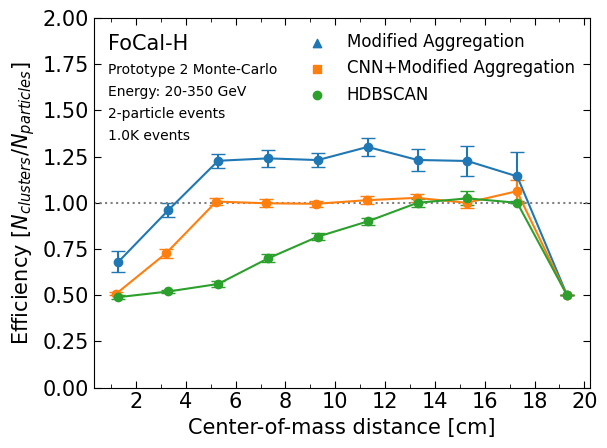

In [14]:
ma_two = df_ma["particles"] == 2
cnn_two = df_cnn["particles"] == 2
hdbscan_two = df_hdbscan["particles"] == 2
bins=10
fig,ax = plt.subplots()
#plot_performance_particle_num(df_ma[ma_two], "coms_dists", "vmeasure", marker_shape="^", linestyle="dashed", ax=ax)
plot_chunks(df_ma[ma_two]["coms_dists"], df_ma[ma_two]["efficiency"], bins, "Modified Aggregation", "o", "", ax)
plot_chunks(df_cnn[cnn_two]["coms_dists"], df_cnn[cnn_two]["efficiency"], bins, "CNN+Modified Aggregation", "o", "", ax)
plot_chunks(df_hdbscan[hdbscan_two]["coms_dists"], df_hdbscan[hdbscan_two]["efficiency"], bins, "HDBSCAN", "o", "", ax)

ax.set_xticks(
    [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    ["0", "2", "4", "6", "8", "10", "12", "14", "16", "18", "20"])
ax.set_ylim(0,2)
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("both")
ax.set_xlabel("Center-of-mass distance [cm]")
ax.set_ylabel("Efficiency [$N_{clusters}/N_{particles}$]")

ax.scatter([],[], label="Modified Aggregation", marker="^")
ax.scatter([],[], label="CNN+Modified Aggregation", marker="s")
ax.scatter([],[], label="HDBSCAN", marker="o")
ax.legend(framealpha=0)
ax.axhline(1, color="grey", linestyle="dotted")

ax.text(0.03, 0.93, "FoCal-H", transform=plt.gca().transAxes, ha="left", va="center")
ax.text(0.03, 0.86, "Prototype 2 Monte-Carlo", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.80, f"Energy: 20-350 GeV", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.74, f"2-particle events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)
ax.text(0.03, 0.68, f"{format_with_suffix(len(df_ma[ma_two]))} events", transform=plt.gca().transAxes, ha="left", va="center", fontsize=10)


fig.savefig("eval_eff_com.png", bbox_inches="tight")

In [99]:
df_cnn[cnn_two]

,efficiency,vmeasure,coverage,particles,avg_energy,coms_dists
99,1.0,0.163939,0.562266,2.0,350.0,9.564399
100,1.0,0.127150,0.529139,2.0,350.0,10.894630
101,1.5,0.076990,0.602499,2.0,350.0,6.120543
102,1.0,0.167439,0.368071,2.0,350.0,11.438643
103,0.5,0.008726,0.065573,2.0,350.0,0.556123
...,...,...,...,...,...,...
8415,1.5,0.069333,0.064241,2.0,20.0,9.522663
8416,0.5,0.000286,0.012940,2.0,20.0,2.423641
8417,1.5,0.040040,0.304618,2.0,20.0,12.494414
8418,2.0,0.027227,0.668976,2.0,20.0,6.464932


In [3]:
from plotly.io import show

{'seed': 0.2, 'agg': 0.0, 'lr': 0.30884943833786427, 'momentum': 0.0525593791377537, 'epochs': 177}


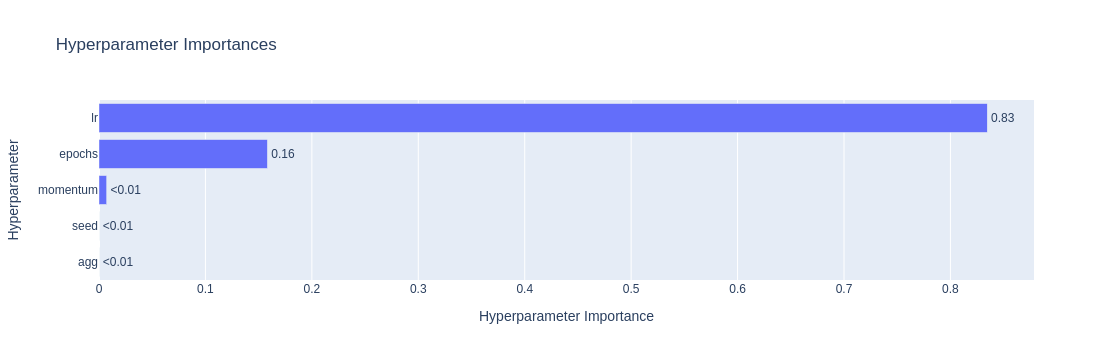

In [5]:
print(cnn_eval["study"]["study"].best_params)
fig = optuna.visualization.plot_param_importances(cnn_eval["study"]["study"])
show(fig)

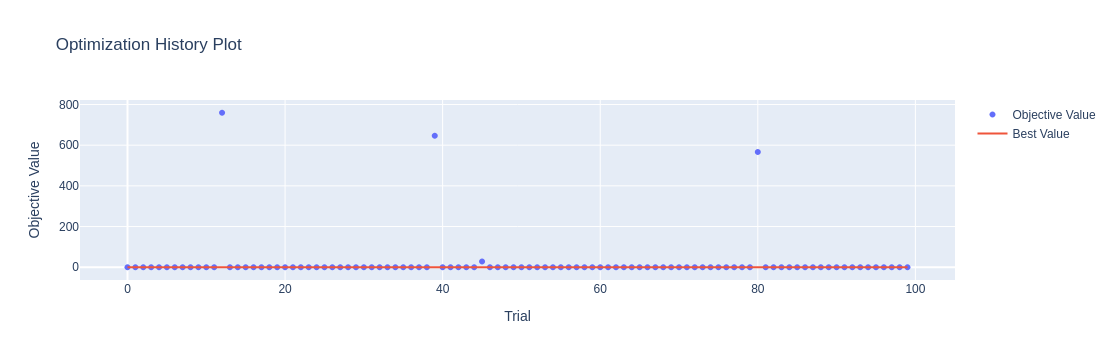

In [10]:
fig = optuna.visualization.plot_optimization_history(cnn_eval["study"]["study"])
show(fig)